In [1]:
import os
import glob
import re

from joblib import Parallel, delayed

import numpy as np

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, KernelPCA
from scipy.spatial.distance import cdist

import MDAnalysis
from MDAnalysis.analysis.rms import RMSD

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

In [2]:
dcds = glob.glob("./peptide-analysis/*/")

# Protein Bioinformatics - Day 3

## Peptide Analysis

Study the evolution over time of three example peptides. The heptapeptides have the following sequence: **AXAHAXA**. In table below, you have the equivalency between the **X** position and the catalytic activity ot the peptide on the reduction of acetophone.

 X | Turnover Frequency ($h^{-1}$)| Conversion (%)          |
:-:|-----------------------------:|------------------------:|
 F | 24                           | 94                      |
 Y | 30                           | 96                      |
 K |  9                           | 81                      |
 D | 17                           | 80                      |
 
 ---
 Analyse the dynamics and answer the following question:
 1. How do the different peptides behave over time? Is there a stable structure or a secondary structure forming?
 *The stability of the peptides depends of the RMSD threshold we choose. If we take a threshold value of 2 $\mathring{A}$, which seems standard according to the litterature, none of the protein is stable. Nevertheless, looking at the RMSD heatmap, we can identify clusters in the trajectories where the peptide has less variation. Looking at these heatmaps, we can hypothesize that the **Lys** might have converge to a more stable conformation as the clusters are more dense. For an additional overview, we tried using K-means to cluster the structures over time for each peptide. As liminary step, we use the Kabsh transform to mitigate rotation and translation of the protein using as reference the centroid of the simulation. To optimize the search of clusters, we used the C-Index computed using RMSD as distance measure, for $k$ between $2$ and $10$. The results are partially satisfying as we do not overestimate the number of cluster in comparison with the heatmap. Using another optimisation index might produce better results here. 
 
 2. Take a snapshot of the centroid of each peptide and compare them.
 *To obtain the centroid of each peptide, we ran the RMSD taking as reference input each frames. We obtained that the **Asp** centroid was at frame 58, the **Lys** centroid was at frame 121, the **Phe** centroid was at frame 99 and the **Tyr** centroid was at frame 136. Visualizing the centroid of the peptides, we observed that **Lys**, **Phe** and **Tyr** presented a similar structure, were not notable secondary structure was formed. **Asp** on the other side presented an $\alpha$-helix.*
 
 3. Can you find any parameter that relates to the turnover frequency? And the conversion?
 *We did not find any parameters related to these values. Molecular Dynamics does not aim to simulate reaction at the electronic level, but rather docking, and thus we cannot study the reduction of acetophone with molecular dynamics. These values are thus not related to the simulation.*


In [3]:
def files_from_dcd_dir(dcd_dir, peptide="peptide", trajectory="output"):
    """
    Return the protein structure file (.pdb) and the trajectory file (.dcd) 
    from a given directory (dcd_dir)
    """
    # Handle unimplemented cases
    if not isinstance(dcd_dir, str):
        raise NotImplementedError()
 
    pdb = os.path.join(dcd_dir, peptide + ".pdb")
    if not os.path.isfile(pdb):
        raise FileNotFoundError()

    dcd = os.path.join(dcd_dir, trajectory + ".dcd")
    if not os.path.isfile(dcd):
        raise FileNotFoundError() 

    re_name = r".*\/(?P<name>.*)\/$"
    match = re.match(re_name, dcd_dir).groupdict()
    name = match['name']

    return pdb, dcd, name

def get_rmsd_from_dcd(dcd_dir, all_frames=False, select="backbone and name CA"):
    """
    Compute the RMSD for a given simulation (use the directory where the files
    are located). If all_frames is True, the rmsd is computed against each frame.
    """
    if not isinstance(select, str):
        raise ValueError()

    # Handle list of results and unimplemented cases
    if isinstance(dcd_dir, (tuple, list)):
        return [get_rmsd_from_dcd(el, all_frames) for el in dcd_dir]
    elif not isinstance(dcd_dir, str):
        raise NotImplementedError()

    pdb, dcd, name = files_from_dcd_dir(dcd_dir)
    u = MDAnalysis.Universe(pdb, dcd)
    ref = u.copy()

    if all_frames:
        rmsds = [RMSD(u, ref, select=select, ref_frame=i).run() for i in range(len(ref.trajectory))]
        rmsds = np.array([R.results.rmsd.T[2] for R in rmsds])

        return name, rmsds

    R = RMSD(u, ref, select=select)
    R.run()
    rmsd = R.results.rmsd.T

    return name, rmsd

def get_centroid_from_dcd(dcd_dir):
    """
    Compute the index of the centroid frame for a given simulation (use the directory where the files
    are located).
    """
    if isinstance(dcd_dir, (tuple, list)):
        return [get_centroid_from_dcd(el) for el in dcd_dir]
    elif not isinstance(dcd_dir, str):
        raise NotImplementedError()

    pdb, dcd, name = files_from_dcd_dir(dcd_dir)
    u = MDAnalysis.Universe(pdb, dcd)
    ref = u.copy()

    _, rmsds = get_rmsd_from_dcd(dcd_dir, all_frames=True)

    similarity_scores = np.exp(- rmsds / np.std(rmsds))
    indices = np.sum(similarity_scores, axis=1)
    centroid_index = np.argmax(indices)

    return name, centroid_index        

def plot_rmsd(rmsd, ax=None, row_length=2, all_frames=False):
    if not isinstance(row_length, int) and row_length >= 1:
        raise ValueError()

    if all_frames:
        plot_rmsd_all_frames(rmsd, ax, row_length)
        return

    if isinstance(rmsd, list):
        n_el = len(rmsd)
        fig, axes = plt.subplots(n_el // row_length, row_length)
        fig.tight_layout(pad=3.0)
        for i, el in enumerate(rmsd):
            plot_rmsd(el, axes[i // row_length, i % row_length]) 
        return

    elif not isinstance(rmsd[0], str) and \
         not isinstance(rmsd[1], np.ndarray):
        raise NotImplementedError()

    if ax is None:
        fig, ax = plt.subplots(1, 1)

    ax.plot(rmsd[1][1], rmsd[1][2])
    ax.set_title(rmsd[0])
    ax.set_ylim(-.1, 6)

def plot_rmsd_all_frames(rmsd, ax=None, row_length=2):
    if not isinstance(row_length, int) and row_length >= 1:
        raise ValueError()

    if isinstance(rmsd, list):
        n_el = len(rmsd)
        fig, axes = plt.subplots(n_el // row_length, row_length)
        fig.tight_layout(pad=3.0)
        for i, el in enumerate(rmsd):
            plot_rmsd_all_frames(el, axes[i // row_length, i % row_length]) 
        return

    elif not isinstance(rmsd[0], str) and \
         not isinstance(rmsd[1], np.ndarray):
        raise NotImplementedError()

    if ax is None:
        fix, ax = plt.subplots(1,1)

    ax.imshow(rmsd[1])
    ax.set_title(rmsd[0])

def save_frame(dcd_dir, frame):
    if not isinstance(dcd_dir, str):
        raise NotImplementedError()

    pdb, dcd, _ = files_from_dcd_dir(dcd_dir)
    u = MDAnalysis.Universe(pdb, dcd)

    if not isinstance(frame, int) and 0 <= frame < len(u.trajectory):
        raise ValueError()

    u.trajectory[frame]
    protein = u.select_atoms("protein")
    protein.write(os.path.join(dcd_dir, "protein.gro"))

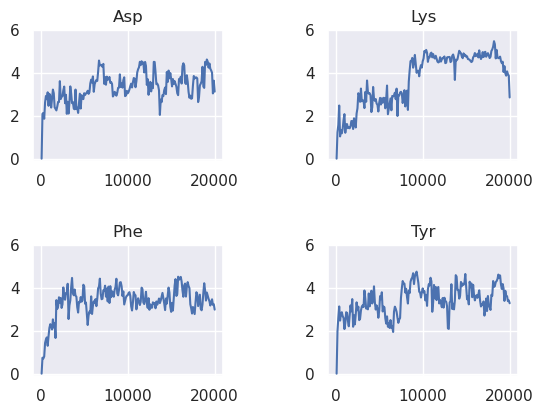

In [4]:
rmsds = get_rmsd_from_dcd(dcds)
plot_rmsd(rmsds)

In [5]:
centroid = get_centroid_from_dcd(dcds)
print(centroid)

[('Asp', 58), ('Lys', 121), ('Phe', 99), ('Tyr', 136)]


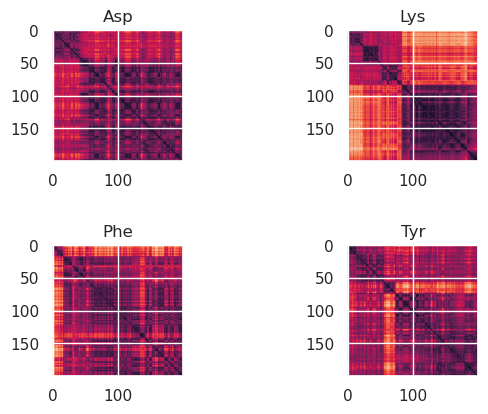

In [6]:
rmsds = get_rmsd_from_dcd(dcds, all_frames=True)
plot_rmsd(rmsds, all_frames=True)

In [7]:
save_frame("./peptide-analysis/Asp/", 58)
save_frame("./peptide-analysis/Lys/", 121)
save_frame("./peptide-analysis/Phe/", 99)
save_frame("./peptide-analysis/Tyr/", 136)

### Clustering of Trajectories using K-Means and Kabsch Transform

In [8]:
def kabsch_transform(mol1, mol2):
    if mol1.shape[0] != 3 and mol2.shape[0] != 3:
        raise ValueError()
    if mol1.shape[1] != mol2.shape[1]:
        raise ValueError()
        
    mol1_c = np.mean(mol1, axis=1, keepdims=True)
    mol2_c = np.mean(mol2, axis=1, keepdims=True)
    mol1_m = mol1 - mol1_c
    mol2_m = mol2 - mol2_c
    
    A = mol2_m @ mol1_m.T
    U2, S, U1t = np.linalg.svd(A)
    
    d = np.sign(np.linalg.det(U2 @ U1t))
    R = (U2 @ np.diag([1., 1., d])) @ U1t
    t = mol2_c - R @ mol1_c
    
    mol1_updated = (R @ mol1 + t).T
    return mol1_updated

def get_tensor_from_dcd(dcd_dir, select="backbone and name CA", n_jobs=8):
    if isinstance(dcd_dir, (tuple, list)):
        return [get_tensor_from_dcd(el) for el in dcd_dir]
    elif not isinstance(dcd_dir, str):
        raise NotImplementedError()
        
    pdb, dcd, name = files_from_dcd_dir(dcd_dir)
    u = MDAnalysis.Universe(pdb, dcd)
    
    # Centroid coordinates
    _, centroid = get_centroid_from_dcd(dcd_dir)
    u.trajectory[centroid]
    centroid = u.atoms.select_atoms(select)
    centroid = np.array([el.position for el in centroid])
    
    # Compute average using Kabsch transform to mitigage protein
    # rotation and translation
    def run_kabsch(universe):
        struct = universe.atoms.select_atoms(select)
        struct = np.array([el.position for el in struct])
        return kabsch_transform(struct.T, centroid.T)
    
    tensor = Parallel(n_jobs=n_jobs)(delayed(run_kabsch)(u) for _ in u.trajectory)
    tensor = np.array(tensor)
    tensor = np.reshape(tensor, (tensor.shape[1], tensor.shape[2], tensor.shape[0]))
        
    return name, tensor

def get_clusters_from_dcd(dcd_dir, init="random", n_clusters=4, n_init=4, random_state=0, min_clusters=2, max_clusters=15, select="backbone and name CA"):
    if isinstance(dcd_dir, (tuple, list)):
        return [get_clusters_from_dcd(el, init, n_clusters, n_init, random_state, min_clusters, max_clusters, select) for el in dcd_dir]
    elif not isinstance(dcd_dir, str):
        raise NotImplementedError()
    
    tensor = get_tensor_from_dcd(dcd_dir, select)
    
    return get_clusters_from_tensor(tensor, init=init, n_clusters=n_clusters, n_init=n_init, random_state=random_state, min_clusters=min_clusters, max_clusters=max_clusters)

def get_clusters_from_tensor(tensor, init="random", n_clusters=4, n_init=4, random_state=0, min_clusters=2, max_clusters=15):
    if isinstance(tensor, list):
        return [get_clusters_from_tensor(el, init, n_clusters, n_init, random_state, min_clusters, max_clusters) for el in tensor]
    elif not isinstance(tensor, tuple) and \
         not isinstance(tensor[0], str) and not isinstance(tensor[1], np.ndarray) and \
         not tensor[1].ndim == 3:
        raise NotImplementedError()
        
    if not n_clusters:
        best_clusters = None
        best_labels = None
        best_c_index = np.infty
        indices = []
        for n in range(min_clusters, max_clusters+1):
            _, clusters, labels = get_clusters_from_tensor(tensor, init, n, n_init, random_state)
            c_index = get_c_index(labels, tensor[1])
            indices += [c_index]
            if c_index < best_c_index:
                best_clusters = clusters
                best_labels = labels
                best_c_index = c_index
                
        return tensor[0], best_clusters, best_labels, indices
    
    data = np.reshape(tensor[1], (tensor[1].shape[2], tensor[1].shape[0], tensor[1].shape[1]))
    data = np.reshape(data, (data.shape[0], data.shape[1]*data.shape[2]))
    
    kmeans = KMeans(init=init, n_clusters=n_clusters, n_init=n_init, random_state=random_state)
    kmeans.fit_transform(data)
    
    clusters = kmeans.cluster_centers_
    clusters = np.reshape(clusters, (clusters.shape[1], n_clusters))
    clusters = np.reshape(clusters, (tensor[1].shape[0], tensor[1].shape[1], n_clusters))
    
    labels = kmeans.labels_
    return tensor[0], clusters, labels

def get_c_index(labels, tensor):
    Gamma = 0
    alpha = 0
    rmsds = []
    for i in range(len(labels) - 1):
        for j in range(i+1, len(labels)):
            rmsds.append(rmsd(tensor[:, :, i], tensor[:, :, j]))
            if labels[i] == labels[j]:
                alpha += 1
                Gamma += rmsds[-1]
    rmsds = np.array(rmsds)
    rmsds = np.sort(rmsds)
    
    d_min = np.sum(rmsds[:alpha])
    d_max = np.sum(rmsds[-alpha:])
    
    C = (Gamma - d_min ) / (d_max - d_min)
    return C  

def rmsd(mol1, mol2):
    if not mol1.shape == mol2.shape:
        raise NotImplementedError()
        
    val = np.subtract(mol1, mol2)
    val = np.sum(np.power(val, 2), axis=1)
    val = np.sum(val) / val.shape[0]
    val = np.power(val, .5)
    return val

def get_most_common_cluster(clusters):
    if isinstance(clusters, list):
        return [get_most_common_cluster(el) for el in clusters]
    elif not isinstance(clusters, tuple) and \
         not (len(clusters) == 3 or len(clusters) == 4):
        raise NotImplementedError()
        
    unique, counts = np.unique(clusters[2], return_counts=True)
    most_common_label = unique[np.argmax(counts)]
    
    return clusters[0], most_common_label, np.max(counts)

def plot_clusters(clusters, tensor, pca=PCA(n_components=2), ax=None, row_length=2):
    if isinstance(clusters, list) and \
       isinstance(tensor, list) and \
       len(clusters) == len(tensor):
        n_el = len(clusters)
        fig, axes = plt.subplots(n_el // row_length, row_length)
        fig.tight_layout(pad=3.0)
        for i, (el_clu, el_ten) in enumerate(zip(clusters, tensor)):
            plot_clusters(el_clu, el_ten, pca, axes[i // row_length, i % row_length]) 
        return

    elif not (isinstance(clusters, tuple) and len(clusters) == 3) and \
         not (isinstance(tensor, tuple) and len(tensor) == 2):
        raise NotImplementedError()
        
    if not clusters[0] == tensor[0]:
        raise ValueError()
        
    data = np.reshape(tensor[1], (tensor[1].shape[2], tensor[1].shape[0], tensor[1].shape[1]))
    data = np.reshape(data, (data.shape[0], data.shape[1]*data.shape[2]))
    labels = clusters[2]
    
    transformed = pca.fit_transform(data)
    
    if ax is None:
        fig, ax = plt.subplots(1, 1)
        
    ax.scatter(transformed[:, 0], transformed[:, 1], c=labels, cmap='tab10')
    ax.set_title(clusters[0])

[('Asp', 0, 144), ('Lys', 1, 112), ('Phe', 0, 167), ('Tyr', 1, 150)]

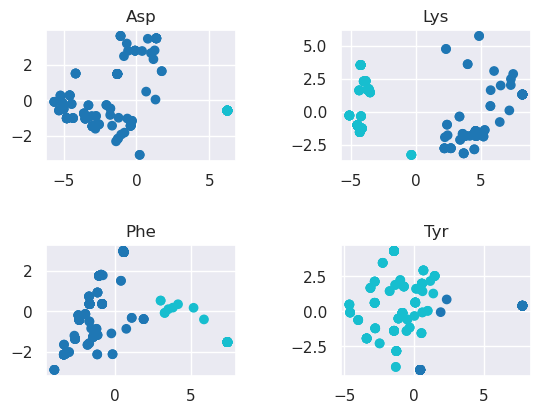

In [9]:
tensor = get_tensor_from_dcd(dcds)
clusters = get_clusters_from_tensor(tensor, n_clusters=0, min_clusters=2, max_clusters=10)
plot_clusters(clusters, tensor)
get_most_common_cluster(clusters)